# Simple Image Processing

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bacalhau-project/examples/blob/main/data-engineering/image-processing/index.ipynb)
[![Open In Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/bacalhau-project/examples/HEAD?labpath=data-engineering%2Fimage-processing%2Findex.ipynb)

In this example, we will show you how to use Bacalhau to process images on a Landsat dataset.

Bacalhau has the unique capability of operating at a massive scale in a distributed environment. This is made possible because data is naturally sharded across the IPFS network amongst many providers. We can take advantage of this to process images in parallel.

However, before we do that, this notebook shows you how to use Bacalhau to process images using a [much smaller subset](https://cloudflare-ipfs.com/ipfs/QmeZRGhe4PmjctYVSVHuEiA9oSXnqmYa4kQubSHgWbjv72). This is useful for testing and debugging your code.

For a live walk-through of this demo please watch the first part of the video below, otherwise feel free to run the demo yourself by following the steps below.

[![Bacalhau Intro Video](/img/Bacalhau_Intro_Video_thumbnail.jpg)](https://www.youtube.com/watch?v=wkOh05J5qgA)

## Prerequistes

Make sure you have the latest `bacalhau` client installed by following the [getting started instructions](../../../getting-started/installation), or using the installation command below (which installs Bacalhau local to the notebook).

In [11]:
!command -v bacalhau >/dev/null 2>&1 || (export BACALHAU_INSTALL_DIR=.; curl -sL https://get.bacalhau.org/install.sh | bash)
path=!echo $PATH
%env PATH=./:{path[0]}

env: PATH=./:./:/Users/phil/.pyenv/versions/3.9.7/bin:/opt/homebrew/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/Users/phil/.gvm/bin:/opt/homebrew/opt/findutils/libexec/gnubin:/opt/homebrew/opt/coreutils/libexec/gnubin:/opt/homebrew/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/Users/phil/.pyenv/shims:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/MacGPG2/bin:/Users/phil/.nexustools


In [12]:
%%bash
bacalhau version

Client Version: v0.2.3
Server Version: v0.2.3


## Submit the workload

To submit a workload to Bacalhau you can use the `bacalhau docker run` command. This allows you to pass input data volume with a `-v CID:path` argument just like Docker, except the left-hand side of the argument is a [content identifier (CID)](https://github.com/multiformats/cid). This results in Bacalhau mounting a *data volume* inside the container. By default, Bacalhau mounts the input volume at the path `/inputs` inside the container.

Bacalhau also mounts a data volume to store output data. By default `bacalhau docker run` creates an output data volume mounted at `/outputs`. This is a convenient location to store the results of your job. See below for an example.

In [13]:
%%bash --out job_id
bacalhau docker run \
  --wait \
  --wait-timeout-secs 100 \
  --id-only \
  -v QmeZRGhe4PmjctYVSVHuEiA9oSXnqmYa4kQubSHgWbjv72:/input_images \
  dpokidov/imagemagick:7.1.0-47-ubuntu \
  -- magick mogrify -resize 100x100 -quality 100 -path /outputs '/input_images/*.jpg'

In [14]:
%env JOB_ID={job_id}

env: JOB_ID=deec77f2-e13c-4505-970f-842c7713a48a


The job has been submitted and Bacalhau has printed out the related job id.
We store that in an environment variable so that we can reuse it later on.

In [15]:
%%bash
bacalhau list --id-filter=${JOB_ID} --no-style

 CREATED   ID        JOB                      STATE      VERIFIED  PUBLISHED               
 15:15:41  deec77f2  Docker dpokidov/imag...  Published            /ipfs/bafybeidtitnyf... 


Since the job state is published/complete, the job is ready to be downloaded.

## Get results

First, let us create a new directory that will store our job outputs.
Second, use the `get` verb to download the job outputs into the directory specified by the `--output-dir` argument.
_Please ignore the `> /dev/null 2>&1` portion of the command, it is there only temporarily until we fix this [issue #614](https://github.com/filecoin-project/bacalhau/issues/614) and is meant to supress debug logs that are not useful for the user._

In [17]:
%%bash
mkdir -p ./results # Temporary directory to store the results
bacalhau get --output-dir ./results ${JOB_ID} # Download the results

16:16:02.846 | INF bacalhau/get.go:67 > Fetching results of job 'deec77f2-e13c-4505-970f-842c7713a48a'...
16:16:05.539 | INF ipfs/downloader.go:115 > Found 1 result shards, downloading to temporary folder.
16:16:12.377 | INF ipfs/downloader.go:195 > Combining shard from output volume 'outputs' to final location: '/Users/phil/source/bacalhau-project/examples/data-engineering/image-processing/results'


The docker run command above used the `outputs` volume as a results folder so when we download them they will be stored in a  folder within `volumes/outputs`.

In [18]:
%%bash
ls -lah results/volumes/outputs

total 192K
drwxr-xr-x 11 phil staff 352 Sep 16 16:16 .
drwxr-xr-x  3 phil staff  96 Sep 16 15:09 ..
-rw-r--r--  1 phil staff 15K Sep 16 16:16 cafires_vir_2021231_lrg.jpg
-rw-r--r--  1 phil staff 34K Sep 16 16:16 greatsaltlake_oli_2017210_lrg.jpg
-rw-r--r--  1 phil staff 13K Sep 16 16:16 greecefires_oli_2021222_lrg.jpg
-rw-r--r--  1 phil staff 17K Sep 16 16:16 haitiearthquake_oli_20212_lrg.jpg
-rw-r--r--  1 phil staff 42K Sep 16 16:16 iwojima_tmo_2021225_lrg.jpg
-rw-r--r--  1 phil staff 11K Sep 16 16:16 lakemead_etm_2000220_lrg.jpg
-rw-r--r--  1 phil staff 14K Sep 16 16:16 lapalma_oli_2021141_lrg.jpg
-rw-r--r--  1 phil staff 14K Sep 16 16:16 spainfire_oli_2021227_lrg.jpg
-rw-r--r--  1 phil staff 16K Sep 16 16:16 sulphursprings_oli_2019254_lrg.jpg


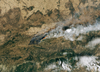

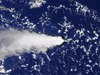

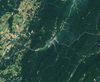

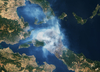

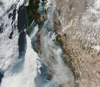

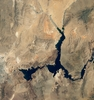

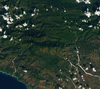

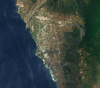

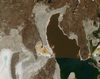

In [20]:
import glob
from IPython.display import Image, display
for imageName in glob.glob('results/volumes/outputs/*.jpg'):
    display(Image(filename=imageName))

## Where to go next?

* [Take a look at other examples](../../index.md)
* [How to run an existing workload on Bacalhau](../../../getting-started/workload-onboarding.md)
* [Check out the Bacalhau CLI Reference page](../../../all-flags.md)

## Support

Please reach out to the [Bacalhau team via Slack](https://filecoinproject.slack.com/archives/C02RLM3JHUY) to seek help or in case of any issues.